<a href="https://colab.research.google.com/github/KotraHaridutt/Brain-Tumor-Classification/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image,ImageSequence,ImageEnhance
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Flatten,Dropout,Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle
from tensorflow.keras.applications import VGG16


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import albumentations as A
from PIL import Image, ImageEnhance # Included for completeness

In [4]:
train_dr = '/content/drive/MyDrive/MRI Images/Training'
test_dr = '/content/drive/MyDrive/MRI Images/Testing'

train_paths = []
train_labels = []
for label in os.listdir(train_dr):
  for image in os.listdir(os.path.join(train_dr, label)):
    train_paths.append(os.path.join(train_dr,label,image))
    train_labels.append(label)

train_paths,train_labels = shuffle(train_paths,train_labels)

test_paths = []
test_labels = []
for label in os.listdir(test_dr):
  for image in os.listdir(os.path.join(test_dr,label)):
    test_paths.append(os.path.join(test_dr,label,image))
    test_labels.append(label)

test_paths,test_labels = shuffle(test_paths,test_labels)

In [5]:
from sklearn.model_selection import train_test_split

# Original train_paths and train_labels
# train_paths, train_labels = shuffle(train_paths, train_labels)

# Split the data into training (80%) and validation (20%)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42
)

print(f"Training images: {len(train_paths)}")
print(f"Validation images: {len(val_paths)}")

Training images: 4569
Validation images: 1143


In [6]:
print(len(train_paths))

4569


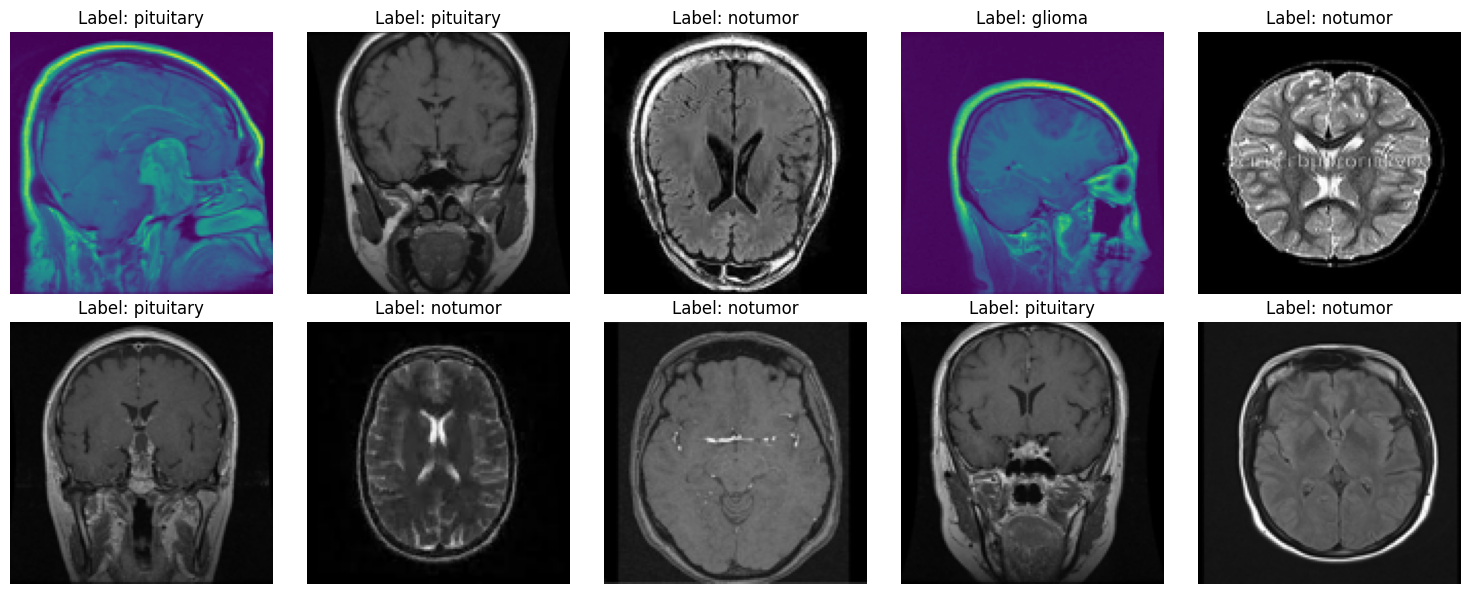

In [ ]:
random_indices = random.sample(range(len(train_paths)),10)


fig,axes = plt.subplots(2,5,figsize = (15,6))
axes = axes.ravel()

for i,indx in enumerate(random_indices):
  img_path = train_paths[indx]
  img = Image.open(img_path)
  img = img.resize((128,128))

  axes[i].imshow(img)
  axes[i].axis('off')

  axes[i].set_title(f"Label: {train_labels[indx]}")

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 128
BATCH_SIZE = 20

'''def custom_augment(image):
    image = Image.fromarray(np.uint8(image))  # Ensure it's PIL image
    image = ImageEnhance.Contrast(image).enhance(np.random.uniform(0.8, 1.2))
    image = np.array(image).astype(np.float32)  # <-- ensure float32 for compatibility
    return image

# Create a generator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=custom_augment,
    fill_mode='nearest'
)'''

strong_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.3),
    A.ImageCompression(quality_lower=70, quality_upper=95, p=0.4),
    A.OneOf([
        A.Blur(blur_limit=3, p=0.5),
        A.MotionBlur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.CoarseDropout(max_holes=8, max_height=25, max_width=25, p=0.3)
])

def apply_albumentations(image):
    augmented_image = strong_augmentations(image=image)['image']
    return augmented_image
# --- END OF NEW CODE ---


# --- MODIFIED AND UNCHANGED GENERATORS ---
# Create a generator for training data with our new augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=apply_albumentations
)


# Create a generator for validation data WITHOUT augmentation (only rescaling)
# It's crucial that validation and test data are not augmented.
val_datagen = ImageDataGenerator(rescale=1./255)

# Create a DataFrame to pass to the generators
# We need to create dataframes for train, validation, and test sets.

train_df = pd.DataFrame({'filepath': train_paths, 'label': train_labels})
val_df = pd.DataFrame({'filepath': val_paths, 'label': val_labels})
test_df = pd.DataFrame({'filepath': test_paths, 'label': test_labels})


# Create the actual data generators from the dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # No need to shuffle validation data
)

/tmp/ipython-input-2643483864.py:30: UserWarning: Argument(s) 'quality_lower, quality_upper' are not valid for transform ImageCompression
  A.ImageCompression(quality_lower=70, quality_upper=95, p=0.4),
/tmp/ipython-input-2643483864.py:35: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=25, max_width=25, p=0.3)


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from re import T
IMAGE_SIZE = 128
base_model = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),include_top=False,weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dr)),activation='softmax'))

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

batch_size = 20
epochs = 5
steps = int(len(train_paths)/batch_size)
# Callbacks
# Saves the best model based on validation accuracy
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
# Stops training if validation accuracy doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=epochs, # You can increase epochs since EarlyStopping will prevent overfitting
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6790 - loss: 0.7822

229/229 ━━━━━━━━━━━━━━━━━━━━ 1650s 7s/step - accuracy: 0.6794 - loss: 0.7814 - val_accuracy: 0.8889 - val_loss: 0.3243
Epoch 2/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 51s 221ms/step - accuracy: 0.8668 - loss: 0.3545 - val_accuracy: 0.8390 - val_loss: 0.4194
Epoch 3/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.8929 - loss: 0.2859

229/229 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.8930 - loss: 0.2858 - val_accuracy: 0.9143 - val_loss: 0.2383
Epoch 4/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 51s 223ms/step - accuracy: 0.9177 - loss: 0.2299 - val_accuracy: 0.8985 - val_loss: 0.2699
Epoch 5/5
229/229 ━━━━━━━━━━━━━━━━━━━━ 51s 222ms/step - accuracy: 0.9227 - loss: 0.1935 - val_accuracy: 0.9116 - val_loss: 0.2341


In [8]:
# =================== FINAL TRAINING SCRIPT ===================

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os # Ensure os is imported if you use it for class count

# --- 1. Define Model Architecture ---

# Constants
IMAGE_SIZE = 128
# Make sure 'train_dr' is the path to your main training directory
# Example: train_dr = 'path/to/your/Training'
NUM_CLASSES = len(os.listdir(train_dr))


# Load VGG16 as the base model, pre-trained on ImageNet
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

# Freeze all layers in the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers of VGG16 to fine-tune them on your specific task
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


# Create the final model by adding your custom classifier on top of VGG16
model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.2),
    Dense(NUM_CLASSES, activation='softmax')
])

# --- 2. Compile the Model ---

print("Compiling model...")
model.compile(
    optimizer=Adam(learning_rate=0.0001), # Low learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model's architecture
model.summary()


# --- 3. Define Callbacks ---

# Saves the best version of the model based on validation loss
checkpoint = ModelCheckpoint(
    "brain_tumor_best_model.keras", # Use the modern .keras format
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Stops training if validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # Increased patience can be helpful
    restore_best_weights=True,
    mode='min',
    verbose=1
)


# --- 4. Start Training ---

print("\nStarting model training...")

# The model will train using the generators you created in the previous cell
history = model.fit(
    train_generator,
    epochs=50, # Set a high number of epochs; EarlyStopping will find the best one
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping]
)

print("\nTraining complete.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)


Starting model training...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3128 - loss: 1.5802
Epoch 1: val_loss improved from inf to 0.58623, saving model to brain_tumor_best_model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 1554s 7s/step - accuracy: 0.3128 - loss: 1.5798 - val_accuracy: 0.8206 - val_loss: 0.5862
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3492 - loss: 1.3561
Epoch 2: val_loss improved from 0.58623 to 0.46249, saving model to brain_tumor_best_model.keras
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.3492 - loss: 1.3561 - val_accuracy: 0.8583 - val_loss: 0.4625
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.3559 - loss: 1.3135
Epoch 3: val_loss did not improve from 0.46249
229/229 ━━━━━━━━━━━━━━━━━━━━ 28s 120ms/step - accuracy: 0.3559 - loss: 1.3135 - val_accuracy: 0.8329 - val_loss: 0.5379
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3653 - loss: 1.3185
Epoch 4: val_loss improved from 0.46249 to 0.39768, sav

In [9]:
# Create a generator for the test set (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Load the best model saved by the checkpoint
from tensorflow.keras.models import load_model
best_model = load_model('brain_tumor_best_model.keras')

# Evaluate the model on the test data
evaluation = best_model.evaluate(test_generator)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

Found 1311 validated image filenames belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 329s 5s/step - accuracy: 0.9451 - loss: 0.1598
Test Accuracy: 94.58%


In [ ]:
from tensorflow.keras.models import load_model
final_model = load_model('/content/drive/MyDrive/best_model.h5')

In [ ]:
import tensorflow as tf
full_model = tf.keras.models.load_model('/content/drive/MyDrive/best_model.h5')

full_model.save_weights('brain_tumor_model_weights_complete.weights.h5')

print("✅ A new, complete weights file has been saved!")

✅ A new, complete weights file has been saved!


In [11]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np

# Load the model you trained and evaluated
final_model = load_model('brain_tumor_best_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


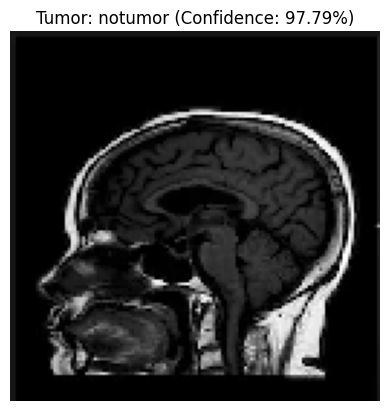

In [13]:
# Example usage of your updated prediction function
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# You can get the class labels programmatically from the generator
#class_labels = list(train_generator.class_indices.keys())

class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']


def detect_and_display(img_path, model, image_size=128, class_labels=class_labels):
    # Load and preprocess the image (ONLY RESCALE)
    img = load_img(img_path, target_size=(image_size, image_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make a prediction
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence_score = np.max(predictions, axis=1)[0]
    result = f"Tumor: {class_labels[predicted_class_index]}"

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
    plt.show()

# Example usage
image_path = '/content/drive/MyDrive/Te-noTr_0004.jpg'
detect_and_display(image_path, final_model)

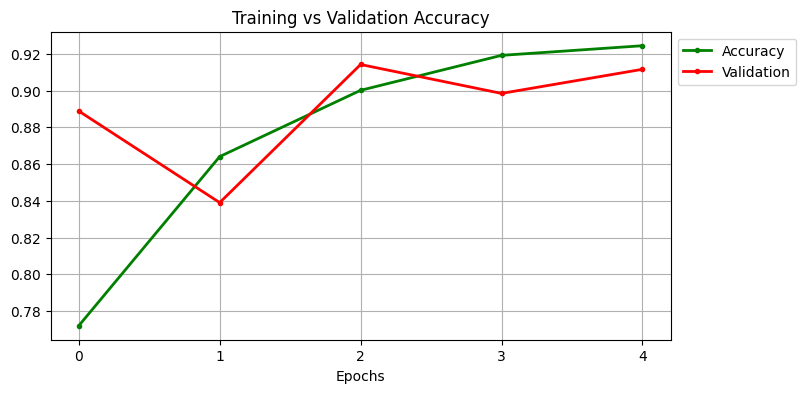

In [ ]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['accuracy'],'.g-',linewidth = 2)
plt.plot(history.history['val_accuracy'],'.r-',linewidth=2)
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy','Validation'],loc='upper left',bbox_to_anchor=(1,1))

plt.show()

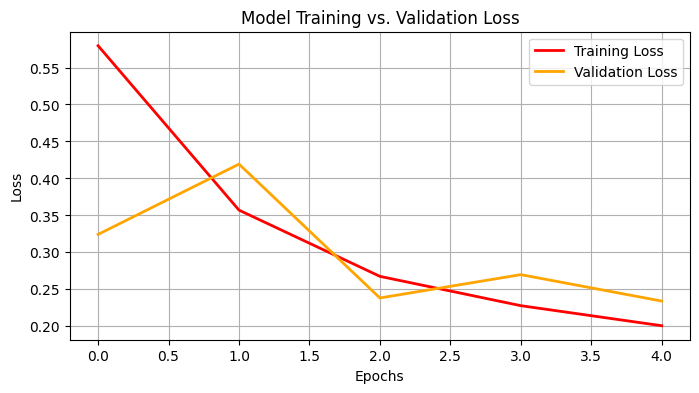

In [ ]:
# --- Create a plot for training and validation loss ---
plt.figure(figsize=(8, 4))
plt.grid(True)
plt.plot(history.history['loss'], 'r-', linewidth=2)      # Plot training loss
plt.plot(history.history['val_loss'], 'orange', linewidth=2) # Plot validation loss
plt.title('Model Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [ ]:
# 1. Make predictions on the test set using the generator
# The 'best_model' is the one loaded from your .h5 file
from sklearn.metrics import classification_report,confusion_matrix
predictions = best_model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# 2. Get the true labels from the generator
y_true = test_generator.classes

# 3. Get the class names from the generator
class_names = list(test_generator.class_indices.keys())

# 4. Generate the Classification Report
print("\n--- Final Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_names))
print("-------------------------------------\n")

66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step

--- Final Classification Report ---
              precision    recall  f1-score   support

      glioma       0.92      0.82      0.87       300
  meningioma       0.84      0.85      0.85       306
     notumor       0.93      0.97      0.95       405
   pituitary       0.93      0.96      0.94       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.91      0.90      1311

-------------------------------------




--- Confusion Matrix ---


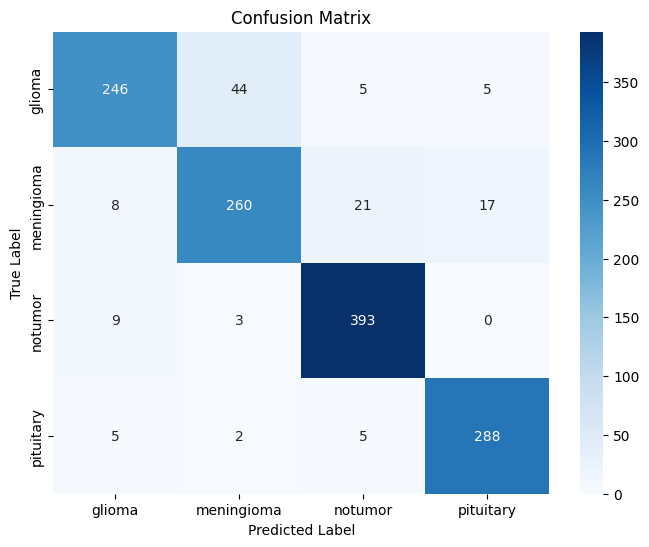

In [ ]:
import seaborn as sns
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step


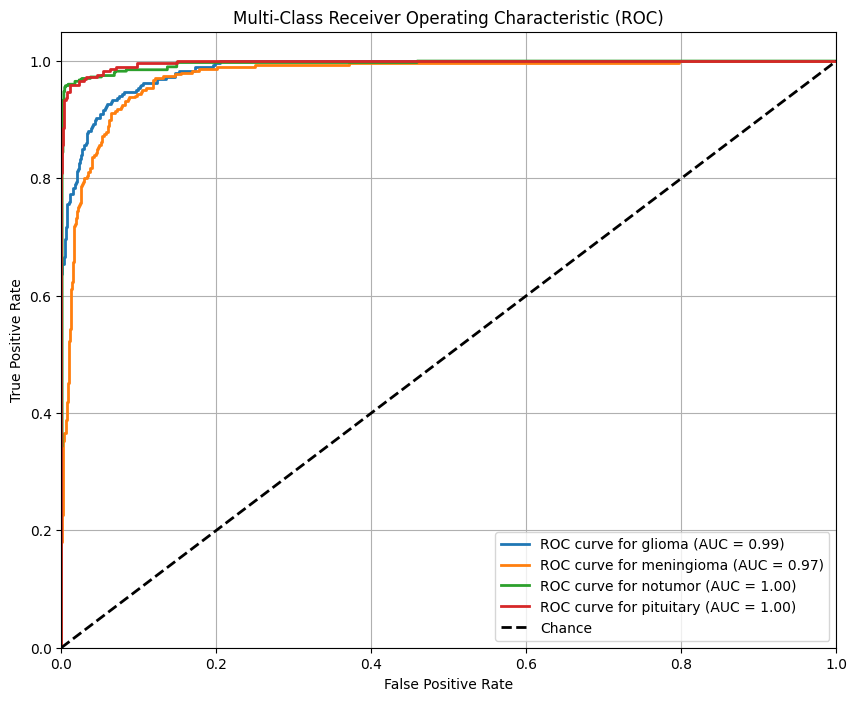

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 1. Get predictions and true labels from the test generator
# 'best_model' is the one loaded from your .h5 file
y_pred_probs = best_model.predict(test_generator)
y_true = test_generator.classes
class_names = list(test_generator.class_indices.keys())
n_classes = len(class_names)

# 2. Binarize the true labels to a one-hot encoded format
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# 3. Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # Compare the one-hot encoded true labels with the model's probability scores
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot all ROC curves
plt.figure(figsize=(10, 8))

# Plot each class's ROC curve
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve for {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the "chance" line (a classifier with no skill)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
!cp /content/best_model.h5 /content/drive/MyDrive/